Introduction for Psychologists:

Hello. This is a demo of our model on predicting depression risk and explaining with features and cases. It is trained on a data set of cases.

**Case**: a survey participant who answered 102 questions of depression screening survey (self-reporting). Each participant has a depression risk score 0,1,2 (judged by a psychologist, based on number of depression-related physical symptoms)

**Feature**: Answers to survey questions (yes/no)

**Query**: the new client who we are making a prediction on.

**How does it work:**
 Our model learns about important features and cases during training. Given a new query (a new client), our model makes a prediction by retrieving the most relevant cases. It can explain in two main ways: highlighting (non-)important features, or highlighting (non-)important cases.

**Goal**: The Goal of this demo is not to show you how good or how bad our model performs but more to open up a discussion about what you feel about using such models (part 2 of the interview). Please ignore the non-existing User-experience (UI) and the software code aspects because it is just a prototype. I will do my best to show you only the relevant parts.

# 1 Setup

On google colab, you have to restart runtime after running the following line

In [ ]:
# !pip install omegaconf

In [ ]:
folder_name = './'

In [ ]:
##This is added because my Rdata uses Cdata for the covid data set.
##Rdata use Cdata function to load the data set, then convert it to regression problem
import os
import sys
sys.path.append(folder_name + 'dataset')


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

from dataset import cls_small_data as Cdata
from dataset import cls_medium_data

from dataset import reg_data as Rdata

/nfs/nfs8/home/research/ml/ego4d.NOBACKUP/wang/dlenv/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/nfs/nfs8/home/research/ml/ego4d.NOBACKUP/wang/dlenv/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [ ]:
conf_file = OmegaConf.load(os.path.join(folder_name, 'config.yaml'))

In [ ]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
random_seed = 43

In [ ]:
debug_print = False
def dprint(*args):
  global debug_print
  if debug_print:
    print(*args)

In [ ]:
import importlib
# importlib.reload(Rdata)
# importlib.reload(Cdata)
importlib.reload(cls_medium_data)

# 2 Data Sets

## SST

### Deprecated

In [ ]:
dataset_name = "sst1"

In [ ]:
num_classes = 5 if dataset_name == "sst1" else 2

In [ ]:
num_classes

5

Version 1, 5 labels

Version 2, 2 labels, take out neutral

In [ ]:
train_data, val_data, test_data = cls_medium_data.Cls_medium_data(dataset_name)

In [ ]:
train_data.shape, val_data.shape, test_data.shape

((8544, 4), (1101, 4), (2210, 4))

In [ ]:
train_data[0, 0]

{'sentence': ["The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .",
  "The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal ."],
 'label': [3.0, 3.0],
 'tokens': ["The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|.",
  "The|Rock|is|destined|to|be|the|21st|Century|'s|new|``|Conan|''|and|that|he|'s|going|to|make|a|splash|even|greater|than|Arnold|Schwarzenegger|,|Jean-Claud|Van|Damme|or|Steven|Segal|."],
 'tree': ['70|70|68|67|63|62|61|60|58|58|57|56|56|64|65|55|54|53|52|51|49|47|47|46|46|45|40|40|41|39|38|38|43|37|37|69|44|39|42|41|42|43|44|45|50|48|48|49|50|51|52|53|54|55|66|57|59|59|60|61|62|63|64|65|66|

In [ ]:
import nltk
# nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

In [ ]:
from collections import Counter

def build_vocab(dataset, min_freq=1):
    """
    Build a vocabulary from the 'sentence' field of the dataset.
    Returns:
      word2idx: dict mapping token -> integer index
      idx2word: list or dict mapping integer index -> token (optional)
    """
    special_tokens = ["<pad>", "<unk>"]
    counter = Counter()

    for i in range(len(dataset)):
        text = dataset[i]['sentence']
        tokens = word_tokenize(text)
        counter.update(tokens)

    # Keep tokens with frequency >= min_freq
    vocab = [word for word, freq in counter.items() if freq >= min_freq]
    vocab = sorted(vocab)

    # Build mapping
    word2idx = {}
    for i, sp_tok in enumerate(special_tokens):
        word2idx[sp_tok] = i

    for i, word in enumerate(vocab, start=len(special_tokens)):
        word2idx[word] = i

    return word2idx

word2idx = build_vocab(train_data, min_freq=2)  # e.g., min_freq=2 might remove rarer words
idx2word = {v:k for k,v in word2idx.items()}

PAD_IDX = word2idx["<pad>"]
UNK_IDX = word2idx["<unk>"]
vocab_size = len(word2idx)
print(f"Vocab size: {vocab_size}")

Vocab size: 8740


In [ ]:
# import torch
from torch.utils.data import DataLoader, TensorDataset
# from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence

# Let's assume you already have:
# train_data, val_data, test_data (dicts with 'sentence' and 'label')
# vocab (a dict {token: index, ..., "<pad>": some_int})
# tokenizer (a function that tokenizes string -> list of tokens)

def prepare_dataset(data, vocab, tokenizer):
    texts = data["sentence"]
    labels = data["label"]
    # Convert each text to a list of token indices
    tokenized_texts = [
        torch.tensor([vocab.get(token, vocab["<unk>"])  # default to <unk> if missing
                      for token in tokenizer(text)], dtype=torch.long)
        for text in texts
    ]
    # Pad to the max length in this batch
    padded_texts = pad_sequence(tokenized_texts, batch_first=True, padding_value=vocab["<pad>"])

    labels = torch.tensor(labels, dtype=torch.long)
    return padded_texts, labels

# Example usage:
X_train, y_train = prepare_dataset(train_data, word2idx, word_tokenize)
X_val,   y_val   = prepare_dataset(val_data,   word2idx, word_tokenize)
X_test,  y_test  = prepare_dataset(test_data,  word2idx, word_tokenize)

train_dataset = TensorDataset(X_train, y_train)
val_dataset   = TensorDataset(X_val,   y_val)
test_dataset  = TensorDataset(X_test,  y_test)


In [ ]:
# from torch.utils.data import Dataset, DataLoader

# class SST2DocDataset(Dataset):
#     def __init__(self, hf_dataset, word2idx, offset_doc_id=0):
#         self.hf_dataset = hf_dataset
#         self.word2idx = word2idx
#         self.offset_doc_id = offset_doc_id  # so we can keep doc IDs globally unique across train/val/test

#     def __len__(self):
#         return len(self.hf_dataset)

#     def __getitem__(self, idx):
#         item = self.hf_dataset[idx]
#         text = item['sentence']
#         label = item['label']  # 0 or 1

#         # doc_id is index in dataset + some offset
#         doc_id = idx + self.offset_doc_id

#         tokens = word_tokenize(text)
#         token_ids = [self.word2idx.get(t, self.word2idx["<UNK>"]) for t in tokens]

#         return {
#             'doc_id': doc_id,
#             'token_ids': token_ids,
#             'label': label
#         }

# def collate_fn(batch):
#     """
#     batch: list of dicts with keys ['doc_id', 'token_ids', 'label'].
#     We'll pad token_ids to the max length in the batch.
#     Returns:
#       doc_id_tensor (batch_size,)
#       padded_tokens (batch_size, max_len)
#       seq_lengths   (batch_size,) - actual lengths before padding
#       labels        (batch_size,)
#     """
#     doc_ids = [x['doc_id'] for x in batch]
#     labels  = [x['label'] for x in batch]

#     # Pad token sequences
#     token_lists = [x['token_ids'] for x in batch]
#     seq_lengths = [len(t) for t in token_lists]
#     max_len = max(seq_lengths) if seq_lengths else 1  # handle empty edge case

#     padded_tokens = []
#     for t in token_lists:
#         padding_needed = max_len - len(t)
#         padded = t + [PAD_IDX]*padding_needed
#         padded_tokens.append(padded)

#     # Convert to tensors
#     doc_id_tensor   = torch.tensor(doc_ids, dtype=torch.long)
#     padded_tokens_t = torch.tensor(padded_tokens, dtype=torch.long)
#     seq_len_tensor  = torch.tensor(seq_lengths, dtype=torch.long)
#     label_tensor    = torch.tensor(labels, dtype=torch.long)

#     return doc_id_tensor, padded_tokens_t, seq_len_tensor, label_tensor

In [ ]:
# class Doc2VecModel(nn.Module):
#     def __init__(self, vocab_size, doc_count, embed_dim, num_classes=2):
#         """
#         vocab_size: total number of tokens in vocabulary
#         doc_count:  total number of documents (train + val + test)
#         embed_dim:  dimension of embeddings
#         num_classes: e.g. 2 for binary classification
#         """
#         super().__init__()
#         self.word_embeddings = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embed_dim)

#         # One embedding vector per document ID
#         self.doc_embeddings = nn.Embedding(num_embeddings=doc_count, embedding_dim=embed_dim)

#         # Classifier
#         self.fc = nn.Linear(embed_dim, num_classes)

#     def forward(self, doc_ids, token_ids):
#         """
#         doc_ids:   (batch_size,)
#         token_ids: (batch_size, seq_len)
#         """
#         # Embed the documents -> shape: (batch_size, embed_dim)
#         d_emb = self.doc_embeddings(doc_ids)

#         # Embed each token -> shape: (batch_size, seq_len, embed_dim)
#         w_emb = self.word_embeddings(token_ids)

#         # Average across the sequence dimension to get a single vector per document
#         # Alternatively, you could do sum or an RNN, etc.
#         w_emb_mean = w_emb.mean(dim=1)  # shape: (batch_size, embed_dim)

#         # Combine doc embedding + word embedding
#         doc_vector = d_emb + w_emb_mean  # shape: (batch_size, embed_dim)

#         # Classify
#         logits = self.fc(doc_vector)  # shape: (batch_size, num_classes)
#         return logits

In [ ]:
train_len = len(train_data)
val_len   = len(val_data)
test_len  = len(test_data)

# train_dataset = SST2DocDataset(train_data, word2idx, offset_doc_id=0)
# val_dataset   = SST2DocDataset(val_data,   word2idx, offset_doc_id=train_len)
# test_dataset  = SST2DocDataset(test_data,  word2idx, offset_doc_id=(train_len + val_len))
doc_count = train_len + val_len + test_len

In [ ]:
# # import torch.optim as optim
# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
# val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, collate_fn=collate_fn)
# test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, collate_fn=collate_fn)

# doc_count = len(train_dataset) + len(val_dataset) + len(test_dataset)
# model = Doc2VecModel(
#     vocab_size=vocab_size,
#     doc_count=doc_count,
#     embed_dim=64,   # hyperparameter
#     num_classes=2
# )

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# # Example: single epoch training loop
# for epoch in range(100):
#     model.train()
#     for doc_ids, token_ids, labels in train_loader:
#         # Forward pass
#         logits = model(doc_ids, token_ids)
#         loss = criterion(logits, labels)

#         # Backprop + update
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#     # Evaluate on validation set
#     model.eval()
#     correct, total = 0, 0
#     with torch.no_grad():
#         for doc_ids, token_ids, labels in val_loader:
#             logits = model(doc_ids, token_ids)
#             preds = logits.argmax(dim=1)
#             correct += (preds == labels).sum().item()
#             total   += labels.size(0)
#     val_acc = correct / total
#     print(f"Epoch {epoch+1}, Val Accuracy = {val_acc:.4f}")

In [ ]:
# import torch
# import torch.nn as nn

# class BiLSTMClassifier(nn.Module):
#     def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2):
#         """
#         A purely Bi-LSTM-based classifier:
#           - Embeds tokens
#           - Encodes with a bidirectional LSTM
#           - Classifies based on the final hidden states

#         Args:
#           vocab_size: size of vocabulary for nn.Embedding
#           embed_dim: dimension of each token embedding
#           hidden_dim: hidden size in the LSTM (per direction)
#           num_classes: number of output classes
#         """
#         super().__init__()
#         # If you have a PAD_IDX, you can pass `padding_idx=PAD_IDX` to ignore
#         # the padded positions in the embedding. Otherwise, remove it.
#         self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=0)

#         # Bi-LSTM means num_directions=2 for a single layer
#         self.lstm = nn.LSTM(
#             input_size=embed_dim,
#             hidden_size=hidden_dim,
#             batch_first=True,
#             bidirectional=True
#         )

#         # Dropout to help reduce overfitting
#         # self.dropout = nn.Dropout(0.5)

#         # Because bidirectional => final hidden state has dimensionality 2 * hidden_dim
#         self.fc = nn.Sequential(
#             nn.Linear(hidden_dim * 2, 128),
#             nn.ReLU(),
#             # nn.Dropout(0.2),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, tokens, seq_lengths):
#         """
#         We keep the same input signature for convenience, but `doc_ids` is unused.

#         Args:
#           doc_ids:   (batch_size,) doc IDs [ignored in this model]
#           tokens:    (batch_size, max_len) long tensor of token IDs
#           seq_lengths: (batch_size,) lengths for each sequence (before padding)

#         Returns:
#           logits of shape (batch_size, num_classes).
#         """

#         # [1] Embed the tokens
#         w_emb = self.embedding(tokens)  # (batch_size, max_len, embed_dim)

#         # [2] Pack to ignore padded steps in the LSTM
#         packed_input = nn.utils.rnn.pack_padded_sequence(
#             w_emb,
#             lengths=seq_lengths.cpu(),  # lengths must be on CPU
#             batch_first=True,
#             enforce_sorted=False
#         )

#         # [3] LSTM forward
#         #    h_n has shape (num_layers * num_directions, batch_size, hidden_dim).
#         #    For a single-layer Bi-LSTM => shape is (2, B, hidden_dim).
#         packed_output, (h_n, c_n) = self.lstm(packed_input)

#         # [4] Concatenate the final forward and backward hidden states
#         #    h_n is [2, B, hidden_dim]. Let's reshape to [B, 2*hidden_dim].
#         h_n = h_n.transpose(0, 1).contiguous()  # [B, 2, hidden_dim]
#         h_n = h_n.view(h_n.size(0), -1)         # [B, 2*hidden_dim]

#         # [5] Optional dropout before classification
#         # h_n = self.dropout(h_n)

#         # [6] Classification head
#         logits = self.fc(h_n)  # (batch_size, num_classes)

#         return logits

In [ ]:
import torch
import torch.nn as nn

class BiLSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, hidden_dim=128, num_classes=2, pad_idx=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        # bidirectional => output hidden_dim * 2
        self.lstm = nn.LSTM(
            input_size=embed_dim,
            hidden_size=hidden_dim,
            batch_first=True,
            bidirectional=True
        )

        self.dropout = nn.Dropout(0.5)
        # final linear: 2*hidden_dim -> some intermediate -> ...
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, tokens):
        # 'doc_ids' is ignored in this version
        embedded = self.embedding(tokens)

        # pack so LSTM can skip the padded positions
        # packed = nn.utils.rnn.pack_padded_sequence(
        #     embedded,
        #     seq_lengths.cpu(),
        #     batch_first=True,
        #     enforce_sorted=False
        # )

        _, (h_n, _) = self.lstm(embedded)  # h_n shape: (2, B, hidden_dim) for BiLSTM (1 layer)

        # rearrange to shape (B, 2*hidden_dim)
        h_n = h_n.transpose(0, 1).contiguous().view(tokens.size(0), -1)

        h_n = self.dropout(h_n)
        logits = self.fc(h_n)  # (B, num_classes)
        return logits

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

PAD_IDX = word2idx["<pad>"]  # the integer used for padding
model = BiLSTMClassifier(
    vocab_size=len(word2idx),
    embed_dim=128,
    hidden_dim=128,
    num_classes=num_classes,
    pad_idx=PAD_IDX
)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(100):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        # 1) compute seq_lengths by counting non-pad tokens
        seq_lengths = (X_batch != PAD_IDX).sum(dim=1)

        # 2) forward pass: pass doc_ids=None, tokens=X_batch, seq_lengths=seq_lengths
        logits = model(X_batch)

        loss = criterion(logits, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Evaluate on val set
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            logits = model(X_batch)
            preds = logits.argmax(dim=1)
            correct += (preds == y_batch).sum().item()
            total += y_batch.size(0)
    val_acc = correct / total
    print(f"Epoch {epoch+1} - Train Loss: {total_loss:.4f} Val Acc: {val_acc:.4f}")

model.eval()
correct, total = 0, 0
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        logits = model(X_batch)
        preds = logits.argmax(dim=1)
        correct += (preds == y_batch).sum().item()
        total += y_batch.size(0)
test_acc = correct / total
print(f"Epoch {epoch+1} - Test Acc: {test_acc:.4f}")

# GO

## Feature Extractor

### For Cifar10

https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/

### Set up Feature Extractor

If you don't want feature extractor


# Text Classification Task

https://arxiv.org/pdf/1408.5882

https://github.com/Impavidity/kim_cnn

Training

In [ ]:
class BiLSTMFeatureExtractor(nn.Module):
    def __init__(self, lstm_classifier=None):
        """
        lstm_classifier: a trained BiLSTMClassifier instance
                         whose submodules we'll reuse
        """
        super().__init__()
        # Copy submodules from the trained classifier
        # We won't use fc (the classification head).

        if lstm_classifier is None:
            lstm_classifier = BiLSTMClassifier(
                                vocab_size=len(word2idx),
                                embed_dim=128,
                                hidden_dim=128,
                                num_classes=2,
                                pad_idx=PAD_IDX)

        self.embedding = lstm_classifier.embedding
        self.lstm = lstm_classifier.lstm
        self.feature_dim = None

    def forward(self, tokens):
        """
        Return a fixed-length feature (batch_size, 2*hidden_dim)
        from the final hidden states of the BiLSTM.
        """
        # doc_ids is ignored
        w_emb = self.embedding(tokens)

        packed_output, (h_n, c_n) = self.lstm(w_emb)

        # h_n shape: (num_layers*num_directions, batch_size, hidden_dim)
        # For a single-layer BiLSTM => (2, B, hidden_dim)
        h_n = h_n.transpose(0, 1).contiguous()  # => (B, 2, hidden_dim)
        h_n = h_n.view(h_n.size(0), -1)         # => (B, 2*hidden_dim)

        return h_n

In [ ]:
feature_extractor = BiLSTMFeatureExtractor(None)
# feature_extractor.eval()  # so we don't train it further

In [ ]:
for param in feature_extractor.parameters():
  param.requires_grad = False

In [ ]:
from types import SimpleNamespace
cfg = SimpleNamespace(**{"batch": 100})

In [ ]:
cfg.PATH = os.path.join(folder_name, f'checkpoints/classifier_{dataset_name}.h5')
cfg.patience = 7
cfg.training_epochs = 100

In [ ]:
# for param in feature_extractor.parameters():
#     print(param.requires_grad)

# Sanity Check
Sanity check with a standard NN classifier using the feature extractor

In [ ]:
X_train.shape, X_test.shape

(torch.Size([8544, 53]), torch.Size([2210, 56]))

In [ ]:
# import torch.optim as optim
# from torch.utils.data import DataLoader, TensorDataset

# model.to(device)

# # Define hyperparameters
# learning_rate = 0.0001
# num_epochs = 100  # Extend epochs since early stopping will halt earlier if needed
# patience = 100
# best_loss = float('inf')
# patience_counter = 0
# batch_size = 32  # Mini-batch size

# # Define optimizer
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# # Prepare the DataLoader for batching (Training Data)
# train_dataset = TensorDataset(X_train, y_train)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Prepare the DataLoader for validation/testing (Validation Data)
# val_dataset = TensorDataset(X_test, y_test)
# val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# # Training loop
# for epoch in range(num_epochs):
#     # Train the model for one epoch
#     model.train()
#     for images, labels in train_loader:
#         optimizer.zero_grad()  # Zero the gradients
#         # Move images and labels to the same device as the model
#         images = images.to(device)
#         labels = labels.to(device)
#         # if(dataset_name == 'mnist'):
#         #   # Reshape images to add channel dimension (for CNN models on MNIST)
#         #   images = images.unsqueeze(1)  # Adds channel dimension (B, 1, H, W)

#         # Forward pass
#         outputs = model(images)
#         loss = criterion(outputs, labels)

#         # Backward pass and optimization
#         loss.backward()
#         optimizer.step()

#     # Calculate average loss on validation set after each epoch
#     model.eval()
#     val_loss = 0.0
#     with torch.no_grad():
#         for images, labels in val_loader:
#             # if(dataset_name == 'mnist'):
#             #   images = images.unsqueeze(1)
#             images = images.to(device)
#             labels = labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss += loss.item()

#     avg_epoch_loss = val_loss / len(val_loader)  # Average loss over the validation set
#     print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {avg_epoch_loss:.4f}")

#     # Early stopping based on validation loss
#     if val_loss < best_loss:
#         best_loss = val_loss
#         patience_counter = 0
#         torch.save(model.state_dict(), 'best_model.pth')  # Save the best model
#     else:
#         patience_counter += 1

#     if patience_counter >= patience:
#         print(f"Early stopping triggered after {epoch+1} epochs.")
#         model.load_state_dict(torch.load('best_model.pth'))  # Restore best model
#         break



In [ ]:
# import torch
# from torch.utils.data import DataLoader, TensorDataset

# # Define batch size for testing
# test_batch_size = 128  # Adjust based on memory capacity

# # Prepare the DataLoader for batching the test set
# test_dataset = TensorDataset(X_test, y_test)
# test_loader = DataLoader(test_dataset, batch_size=test_batch_size, shuffle=False)

# correct = 0
# total = 0

# # Evaluation loop using DataLoader
# with torch.no_grad():
#     for images, labels in test_loader:
#         # Reshape for CNNs (e.g., MNIST)
#         # if dataset_name == 'mnist':
#         #     images = images.unsqueeze(1)  # Add channel dimension (B, 1, H, W)
#         images = images.to(device)
#         labels = labels.to(device)
#         # Forward pass over the mini-batch
#         outputs = model(images)
#         _, predicted = torch.max(outputs, 1)  # Get predicted class (max along dim=1)

#         # Accumulate correct predictions
#         correct += (predicted == labels).sum().item()
#         total += labels.size(0)

# # Calculate and print accuracy
# accuracy = 100 * correct / total
# print(f"Accuracy of the model on the test images: {accuracy:.2f}%")


## Pretrained Feature for KNN (Pretrained Conv + KNN)

Run the following if you want to transform the features for vanilla knn

In [ ]:
# Step 1: Freeze the feature extractor's weights
for param in feature_extractor.parameters():
    param.requires_grad = False

# Step 2: Convert X_train and X_test
def transform_dataset(X, feature_extractor, batch_size=128, device='cuda'):
    """
    Transform a dataset using the feature extractor.

    Args:
        X (torch.Tensor): Input dataset of shape (num_samples, channels, height, width).
        feature_extractor (nn.Module): Feature extractor model.
        batch_size (int): Batch size for processing.
        device (str): Device to perform computations ('cuda' or 'cpu').

    Returns:
        torch.Tensor: Transformed dataset of shape (num_samples, feature_dim).
    """
    feature_extractor.eval()  # Ensure the feature extractor is in evaluation mode
    X = X.to(device)
    transformed_features = []

    with torch.no_grad():  # Disable gradient computation for efficiency
        for i in range(0, X.size(0), batch_size):
            batch = X[i:i + batch_size]
            features = feature_extractor(batch)  # Extract features
            transformed_features.append(features)

    return torch.cat(transformed_features, dim=0)

# Transform the datasets
X_train_transformed = transform_dataset(X_train, feature_extractor, batch_size=128, device=device)
X_test_transformed = transform_dataset(X_test, feature_extractor, batch_size=128, device=device)

# Print shapes to verify
print(f"Transformed X_train shape: {X_train_transformed.shape}")
print(f"Transformed X_test shape: {X_test_transformed.shape}")


Transformed X_train shape: torch.Size([8544, 256])
Transformed X_test shape: torch.Size([2210, 256])


In [ ]:
feature_extractor = None

In [ ]:
X_train = X_train_transformed
X_test = X_test_transformed

Sanity check using a vanilla knn

In [ ]:
# prompt: knn on the train and test data set

from sklearn.neighbors import KNeighborsClassifier

# Assuming X_train, y_train, X_test, and y_test are defined from the previous code
# and contain the training and testing data.

# Initialize the k-NN classifier
knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors

# Reshape X_train and X_test to 2D arrays before fitting the k-NN model
X_train_reshaped = X_train.reshape(X_train.shape[0], -1)  # Reshape to (num_samples, height * width)
X_test_reshaped = X_test.reshape(X_test.shape[0], -1)    # Reshape to (num_samples, height * width)

# Train the classifier on the reshaped training data
knn.fit(X_train_reshaped.cpu(), y_train)

# Make predictions on the reshaped test data
y_pred = knn.predict(X_test_reshaped.cpu())

# Evaluate the model (example: accuracy)
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
print(f"k-NN Accuracy: {accuracy}")

k-NN Accuracy: 0.35158371040723985


In [ ]:
# del X_train_transformed, X_test_transformed

# Param Setup


### Shared Param Setup

Must run!

In [ ]:
def get_feature_dim(case, feature_extractor):
        if feature_extractor is None:
            return torch.prod(torch.tensor(case.shape)).item()
        else:
            return feature_extractor.feature_dim

In [ ]:
#if Xs is not defined, use X_train
if 'Xs' not in locals():
    Xs = X_train
    ys = y_train

# feature_dim = get_feature_dim(Xs[0], feature_extractor)# Xs.shape[1]
# glocal_fw_set_num = 4;

# sampling_cases_flag = False
# use_sampling_cases_divisor = False
# sampling_cases_divisor = 100

# #DESIGN DECISION
# case_activation_by_top_k_average = True
# top_k_for_case_activation = 5
# num_samples=5000

# #if case_activation_by_top_k_average = False, following will be used
# case_activation_default_percentage = 0.1  #this might require enabling top k
# top_case_enabled = False

# bias_manual_set = False
# bias_manual_value = 6.0

# model_path = 'best_model.pth'
# feature_weightor_path = 'best_fw.pth'

In [ ]:
case_activation_by_top_k_average = True
bias_manual_set = False
bias_manual_value = 6.0

### Non-shared setup

In [ ]:
#For MNIST
glocal_fw_set_num = 1
sampling_cases_flag = True
top_k_for_case_activation = 20
num_samples=500

In [ ]:
#For Cifar 10

glocal_fw_set_num = 1
sampling_cases_flag = True
top_k_for_case_activation = 20
num_samples=500

In [ ]:
#For SVHN

glocal_fw_set_num = 4
sampling_cases_flag = True
top_k_for_case_activation = 20
num_samples=500

In [ ]:
#For SST

glocal_fw_set_num = 4
sampling_cases_flag = True
top_k_for_case_activation = 5
num_samples=500

# MUST RUN

In [ ]:
feature_extractor = BiLSTMFeatureExtractor().to(device)

## Glocal Feature Weight

In [ ]:
class GlocalFeatureWeight(nn.Module):
    def __init__(self, feature_dim, set_num):
        """
        Glocal feature weighting module for batched operations.

        Args:
            feature_dim: Dimensionality of the features.
            set_num: Number of glocal weight sets.
        """
        super(GlocalFeatureWeight, self).__init__()
        self.feature_dim = feature_dim

        # Initialize feature weights
        self.feature_weights = nn.Parameter(torch.rand((set_num, feature_dim)), requires_grad=True)
        if glocal_fw_set_num == 1:
            self.feature_weights = nn.Parameter(torch.ones((set_num, feature_dim)), requires_grad=True)  # Shape: (set_num, feature_dim)

    def forward(self, case_distance, glocal_weights):
        """
        Apply feature weighting to the case distance in a batched manner.

        Args:
            case_distance: Tensor of shape (batch_size, sample_num, feature_dim).
            glocal_weights: Tensor of shape (sample_num, set_num).

        Returns:
            weighted_distance: Weighted case distance, shape (batch_size, sample_num, feature_dim).
        """
        global debug_print
        debug_print = False

        # Ensure positive feature weights using LeakyReLU
        pos_feature_weights = F.leaky_relu(self.feature_weights, negative_slope=0.001)  # Shape: (set_num, feature_dim)
        glocal_weights = F.leaky_relu(glocal_weights, negative_slope=0.001)  # Shape: (sample_num, set_num)

        # Compute weight factors for all cases
        # Resulting shape: (sample_num, feature_dim)
        weight_factors = torch.matmul(glocal_weights, pos_feature_weights)  # Shape: (sample_num, feature_dim)

        # Expand weight_factors to match batch size and elementwise multiply
        weighted_distance = case_distance * weight_factors.unsqueeze(0)  # Shape: (batch_size, sample_num, feature_dim)

        if debug_print:
            print("case_distance:", case_distance)
            print("glocal_weights:", glocal_weights)
            print("feature_weights:", self.feature_weights)
            print("weighted_distance:", weighted_distance)

        return weighted_distance


## Case Bias Setup and others

In [ ]:
# prompt: a class recording a case's How often it is activated, how often it is sampled, how often it correctly classifies a query.

class CaseRecord:
    def __init__(self, case_id = None):
        self.case_id = case_id
        self.activation_count = 0
        self.sample_count = 0
        self.correct_classification_count = 0

    def activate(self):
        self.activation_count += 1

    def sample(self):
        self.sample_count += 1

    def correct_classification(self):
        self.correct_classification_count += 1

    def get_activation_rate(self):
        return self.activation_count / (self.sample_count + 1e-10) # avoid division by zero

    def get_sampling_rate(self):
      return self.sample_count

    def get_accuracy(self):
        return self.correct_classification_count / (self.sample_count + 1e-10) # avoid division by zero

In [ ]:
import torch
import torch.nn.functional as F

def find_default_bias(X, feature_extractor = None,num_samples=500, case_activation_default_percentage=0.1):
    """
    Estimates the default bias for CaseNets by randomly comparing pairwise distances.
    Handles both image (e.g., MNIST) and tabular data.

    Args:
        X: The feature tensor. Shape can be (num_cases, feature_dim) or (num_cases, 1, H, W).
        num_samples: The number of random case pairs to compare.
        case_activation_default_percentage: Percentage of sorted distances to select.

    Returns:
        The estimated default bias.
    """
    num_cases = X.shape[0]
    distances = []

    # Flatten if data is image-like (e.g., (num_cases, 1, 28, 28))
    if len(X.shape) > 2:
        X_flat = X.view(num_cases, -1)  # Flatten to (num_cases, feature_dim)
    else:
        X_flat = X  # Already in tabular form
    if feature_extractor is not None:
        # Extract features using the feature extractor
        with torch.no_grad():  # Disable gradient computation for efficiency
            X_flat = feature_extractor(X).view(X.shape[0], -1)  # Flatten to (num_cases, feature_dim)

    # Compute random pairwise distances
    for _ in range(num_samples):
        idx1, idx2 = torch.randint(0, num_cases, (2,))

        # Calculate the pairwise distance
        distance = F.pairwise_distance(X_flat[idx1].unsqueeze(0), X_flat[idx2].unsqueeze(0))
        distances.append(distance.item())

    # Sort distances and select top 10% based on case_activation_default_percentage
    distances.sort()
    percentile_index = int(len(distances) * case_activation_default_percentage)
    default_bias = distances[percentile_index]

    return default_bias


In [ ]:
import torch
import torch.nn.functional as F

def find_default_bias_knn(X, feature_extractor=None, k=5, num_samples=500, batch_size=64):
    """
    Efficiently estimates the default bias for CaseNets by computing the average distance
    to the k-th nearest neighbor for each case, using a randomly sampled subset of cases.

    Args:
        X: The feature tensor, shape (num_cases, channels, height, width) for MNIST or CIFAR-10.
        feature_extractor: Optional feature extractor to transform the input tensor.
        k: The number of nearest neighbors to consider.
        num_samples: Number of random cases to compare against.
        batch_size: Batch size for processing cases.

    Returns:
        The estimated default bias (average distance to the k-th nearest neighbor).
    """
    num_cases = X.shape[0]
    all_kth_distances = []

    # Extract features using the feature extractor, if provided
    if feature_extractor is not None:
        feature_list = []
        with torch.no_grad():
            for i in range(0, num_cases, batch_size):
                batch = X[i:i + batch_size]  # Shape: (batch_size, channels, height, width)
                batch_features = feature_extractor(batch)  # Shape: (batch_size, feature_dim)
                feature_list.append(batch_features)
        X = torch.cat(feature_list, dim=0)  # Concatenate all batches

    # Flatten the features for distance computation
    X_flat = X.view(X.shape[0], -1)  # Shape: (num_cases, feature_dim)

    # Randomly sample `num_samples` cases to form the comparison set
    sampled_indices = torch.randperm(num_cases)[:num_samples]
    sampled_cases = X_flat[sampled_indices]  # Shape: (num_samples, feature_dim)

    # Process cases in batches to reduce memory usage
    for i in range(0, num_cases, batch_size):
        # Get the batch of cases
        batch = X_flat[i:i + batch_size]  # Shape: (batch_size, feature_dim)

        # Compute pairwise distances with the sampled cases
        distances = torch.cdist(batch, sampled_cases)  # Shape: (batch_size, num_samples)

        # Set self-distances to infinity for sampled cases
        batch_indices = torch.arange(i, min(i + batch_size, num_cases))
        mask = (batch_indices.unsqueeze(1) == sampled_indices.unsqueeze(0))  # Match indices in the batch
        distances[mask] = float('inf')

        # Get the k-th smallest distance for each case in the batch
        k_actual = min(k, num_samples)  # Ensure k does not exceed the number of samples
        kth_distances = torch.topk(distances, k=k_actual, largest=False).values[:, -1]
        all_kth_distances.extend(kth_distances.tolist())

    # Return the average k-th neighbor distance as the default bias
    return sum(all_kth_distances) / len(all_kth_distances)


In [ ]:
# feature_extractor = feature_extractor.to(device)

case_default_bias = 0
if bias_manual_set:
  case_default_bias = bias_manual_value
elif case_activation_by_top_k_average:
  case_default_bias = find_default_bias_knn(Xs.to(device), feature_extractor, top_k_for_case_activation, num_samples)
else:
  case_default_bias = find_default_bias(Xs)

In [ ]:
case_default_bias

1.305230148628438

In [ ]:
# Initialize case_default_bias as a GLOBAL trainable parameter
# case_default_bias = nn.Parameter(torch.tensor(find_default_bias(Xs), dtype=torch.float32, device=device), requires_grad=True)


## Case Network

### Custom Case Activation Functions

In [ ]:
import torch
from functools import partial

def scaled_sigmoid(x):
    """
    Scaled and shifted sigmoid as a PyTorch operation.

    Args:
        x: The input tensor.
        A: The value at which the output should be close to 1.

    Returns:
        The scaled and shifted sigmoid output tensor.
    """
    A = case_default_bias
    s = 8 / A  # Scaling factor
    b = 0 - 4      # Shift value
    return torch.sigmoid(s * x + b)


# Now you can use sigmoid_with_preset_A with variable x
x = torch.randn(10)*5  # Example input tensor
output = scaled_sigmoid(x)

In [ ]:
def mirrored_leaky_relu(x, negative_slope= 0.01, threshold = case_default_bias):
    """
    Custom Leaky ReLU with mirrored behavior above a threshold.

    Args:
        x: Input tensor.
        negative_slope: Slope for x < 0.
        threshold: Upper bound where the mirroring begins.

    Returns:
        Transformed tensor.
    """
    # Leaky ReLU for x < 0
    leaky_part = torch.where(x < 0, negative_slope * x, x)

    # Mirroring effect for x > threshold
    mirror_part = torch.where(x > threshold,
                              threshold + negative_slope * (x - threshold),
                              leaky_part)

    return mirror_part


In [ ]:
# prompt: one hot encode ys

import torch
ys = torch.tensor(ys) # Assuming ys is a NumPy array or a list
num_classes = len(torch.unique(ys))
ys_onehot = torch.nn.functional.one_hot(ys, num_classes=num_classes)

/tmp/ipykernel_247083/2926130680.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  ys = torch.tensor(ys) # Assuming ys is a NumPy array or a list


In [ ]:
Xs = Xs.to(device)
ys_onehot = ys_onehot.to(device)
ys = ys.to(device)

### Real Case Network

In [ ]:
cfg.batch_size = 100

In [ ]:
import torch
import torch.nn as nn

class CaseNetsClassifier(nn.Module):
    def __init__(self, cases, labels, feature_extractor=None, glocal_weightor=None, sampling_cases=sampling_cases_flag, top_k=4):
        """
        A combined class that replaces both `CaseNet` and `CaseNetsClassifier`.

        Args:
            cases (torch.Tensor): Tensor containing all cases (e.g., images or sequences).
            labels (torch.Tensor): Tensor of one-hot encoded labels for each case.
            feature_extractor (nn.Module): Feature extractor (e.g., CNN for images or embedding for text).
            glocal_weightor (nn.Module): Global-local weightor for feature weighting.
            sampling_cases (bool): Whether to use sampling for case selection.
            top_k (int): Number of top cases to retrieve for explanation.
        """
        super(CaseNetsClassifier, self).__init__()
        self.cases = cases  # Shape: [num_cases, *case_shape]
        self.labels = labels  # Shape: [num_cases, num_classes]
        self.feature_extractor = feature_extractor
        self.glocal_weightor = glocal_weightor

        # Group cases by class
        self.class_to_cases = {}
        for i, label in enumerate(self.labels):
            class_label = torch.argmax(label).item()  # Extract class label
            if class_label not in self.class_to_cases:
                self.class_to_cases[class_label] = []
            self.class_to_cases[class_label].append(i)

        self.sampling_cases = sampling_cases
        self.sample_num = num_samples
        self.top_k = top_k

        # Parameters specific to each case
        self.biases = nn.Parameter(torch.full((len(cases),), case_default_bias))  # Shape: [num_cases]
        self.weights = nn.Parameter(torch.ones(len(cases)))  # Shape: [num_cases]
        self.glocal_weights = nn.Parameter(
            torch.softmax(torch.ones(len(cases), glocal_fw_set_num), dim=-1)
        )  # Shape: [num_cases, set_dim]

        # Precompute feature dimensions if feature extractor exists
        self.feature_dim = None
        if feature_extractor is not None:
            with torch.no_grad():
                dummy_input = cases[0].unsqueeze(0).to(device)
                self.feature_dim = feature_extractor(dummy_input).shape[-1]
        else:
            self.feature_dim = cases.shape[-1]
        self.cached_features = None  # To cache features during evaluation mode

        self.explanation_mode = False
    def _extract_features(self, case_indices):
        """
        Extract features for selected cases using the feature extractor.

        Args:
            case_indices (torch.Tensor): Indices of cases to process.

        Returns:
            extracted_features (torch.Tensor): Features for the selected cases.
        """
        selected_cases = self.cases[case_indices]  # Shape: [num_selected_cases, *case_shape]

        if self.feature_extractor is not None:
            if self.training:
                # Always compute features during training
                extracted_features = self.feature_extractor(selected_cases)  # Shape: [num_selected_cases, feature_dim]
                #wipe cache because feature extractor will be updated
                self.cached_features = None
            else:
                # During evaluation, update cache only for processed indices
                if self.cached_features is None:
                    # Initialize cache on the first evaluation pass
                    self.cached_features = torch.zeros(
                        (len(self.cases), self.feature_dim), dtype=torch.float32, device=selected_cases.device
                    )

                # Check which indices need to be computed
                uncached_indices = [idx.item() for idx in case_indices if self.cached_features[idx].sum() == 0]
                if uncached_indices:
                    uncached_cases = self.cases[uncached_indices]
                    uncached_features = self.feature_extractor(uncached_cases)  # Extract features for uncached cases
                    self.cached_features[uncached_indices] = uncached_features

                # Retrieve features from the cache
                extracted_features = self.cached_features[case_indices]
        else:
            # No feature extraction; use raw cases as features
            extracted_features = selected_cases

        return extracted_features


    def forward(self, query):
        """
        Perform forward pass and optionally provide explanations.

        Args:
            query (torch.Tensor): Query tensor of shape [batch_size, *query_shape].
            explanation_mode (bool): Whether to provide explanations (top-k cases).

        Returns:
            final_predictions (torch.Tensor): Predicted probabilities/logits for each class.
            predicted_class (torch.Tensor): Predicted class indices.
            most_activated_cases (list, optional): List of top-k most activated cases (if explanation_mode=True).
            most_activated_activations (torch.Tensor, optional): Activations of the top-k most activated cases.
        """
        batch_size = query.size(0)
        num_cases = len(self.cases)
        case_indices = torch.arange(num_cases).to(query.device)  # Default: use all case_nets
        # Sampling cases (optional)
        if self.sampling_cases:
          sampled_indices = []
          each_class_sample_num = max(1, self.sample_num // len(self.class_to_cases))

          for class_label, case_indices in self.class_to_cases.items():
              if len(case_indices) >= each_class_sample_num:
                  # Sample directly from global indices
                  sampled_indices.extend(torch.tensor(case_indices)[torch.randperm(len(case_indices))[:each_class_sample_num]].tolist())
              else:
                  # If fewer cases, sample with replacement
                  sampled_indices.extend(
                      torch.tensor(case_indices)[torch.randint(0, len(case_indices), (each_class_sample_num,))].tolist()
                  )
          case_indices = torch.tensor(sampled_indices).to(query.device)

        # Extract features
        query_features = self.feature_extractor(query) if self.feature_extractor is not None else query
        case_features = self._extract_features(case_indices)

        # Compute distances
        query_expanded = query_features.unsqueeze(1).expand(-1, len(case_indices), -1)  # [batch_size, num_selected_cases, feature_dim]
        case_expanded = case_features.unsqueeze(0).expand(batch_size, -1, -1)  # [batch_size, num_selected_cases, feature_dim]
        elementwise_distance = (query_expanded - case_expanded) ** 2  # Shape: [batch_size, num_selected_cases, feature_dim]

        # Apply global-local weighting if applicable
        if self.glocal_weightor is not None:
            glocal_weights = self.glocal_weights[case_indices]  # [num_selected_cases, set_dim]
            elementwise_distance = self.glocal_weightor(elementwise_distance, glocal_weights)  # Weighted distances

        distances = torch.sqrt(torch.relu(torch.sum(elementwise_distance, dim=-1)))  # [batch_size, num_selected_cases]
        # Convert distances to activations
        activations = self.biases[case_indices] - torch.sqrt(distances)  # [batch_size, num_selected_cases]
        activations = scaled_sigmoid(activations) * self.weights[case_indices]  # Scale by case-specific weights

        # Multiply activations by labels
        selected_labels = self.labels[case_indices]  # [num_selected_cases, num_classes]
        weighted_activations = activations.unsqueeze(2) * selected_labels.unsqueeze(0)  # [batch_size, num_selected_cases, num_classes]

        # Sum over cases to produce predictions
        final_predictions = weighted_activations.sum(dim=1)  # [batch_size, num_classes]
        predicted_class = final_predictions.argmax(dim=1)  # [batch_size]

        # Explanation (Top-k cases)
        most_activated_cases, most_activated_case_labels, most_activated_activations = None, None, None
        if self.explanation_mode:
            top_k_activations, top_k_indices = torch.topk(activations, self.top_k, dim=1)  # [batch_size, top_k]
            most_activated_cases = [self.cases[case_indices[idx]] for idx in top_k_indices]
            most_activated_case_labels = [self.labels[case_indices[idx]] for idx in top_k_indices]
            most_activated_activations = top_k_activations

        return final_predictions, predicted_class, most_activated_cases, most_activated_case_labels, most_activated_activations


Debugging code

In [ ]:
# CNs = CaseNetsClassifier([exampleCN0])
# CNs = CaseNetsClassifier([exampleCN0, exampleCN1])
# CNs = CaseNetsClassifier([exampleCN0, exampleCN1], top_case_enabled=True)
# CNs.eval()
# example_queries = Xs[0:2]
# final_predictions, predicted_class = CNs(example_queries)

In [ ]:
# final_predictions

In [ ]:
# predicted_class

In [ ]:
# for name, param in CNs.named_parameters():
#     print(f"Parameter name: {name}")
#     print(f"Parameter data: {param.data}")
#     print(f"Requires gradient: {param.requires_grad}")
#     print("------")


# MANUAL RUN

## Training Case Network

In [ ]:
# feature_extractor = iniitialize_feature_extractor()

In [ ]:
cfg

namespace(batch=100,
          PATH='./checkpoints/classifier_sst1.h5',
          patience=7,
          training_epochs=100,
          batch_size=100)

In [ ]:
cfg.batch_size = 100

In [ ]:
cfg.PATH = os.path.join(folder_name, f'checkpoints/classifier_{dataset_name}.h5')
cfg.patience = 7
cfg

namespace(batch=100,
          PATH='./checkpoints/classifier_sst1.h5',
          patience=7,
          training_epochs=100,
          batch_size=100)

In [ ]:
for param in feature_extractor.parameters():
    print(param.requires_grad)

True
True
True
True
True
True
True
True
True


In [ ]:
import torch
import torch.nn as nn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score
import os
import numpy as np

def train_model(X_train, y_train, X_val, y_val, cfg, glocal_fw_set_num=glocal_fw_set_num):
    global debug_print
    """
    Train the NN-kNN model using the provided train/validation split.

    Args:
        X_train: Training feature tensor.
        y_train: Training labels.
        X_val: Validation feature tensor.
        y_val: Validation labels.
        cfg: Configuration object with training hyperparameters.
        glocal_fw_set_num: Number of sets for the global feature weightor.

    Returns:
        best_accuracy: The best accuracy achieved during training.
        glocal_weightor: The trained global feature weightor.
    """
    # Move data to the appropriate device
    X_train = X_train.to(device)
    y_train = y_train.to(device)

    # DataLoader for batching
    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_train, y_train),
        batch_size=cfg.batch_size,
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(X_val, y_val),
        batch_size=cfg.batch_size,
        shuffle=False
    )

    # Initialize the global feature weightor
    glocal_weightor = GlocalFeatureWeight(feature_dim, glocal_fw_set_num)
    glocal_weightor.to(device)

    print(glocal_weightor.state_dict())
    # Initialize CaseNet instances for the training set
    # case_nets = [CaseNet(X_train[i], ys_onehot[i], feature_weightor=glocal_weightor) for i in range(len(X_train))]
    # model = CaseNetsClassifier(case_nets, glocal_weightor, feature_extractor)

    model = CaseNetsClassifier(X_train, ys_onehot, feature_extractor, glocal_weightor)
    model.to(device)
    # Separate parameters for different learning rates
    feature_extractor_params = list()
    if(feature_extractor is not None):
        feature_extractor_params = list(feature_extractor.parameters())
    glocal_weightor_params = list(model.glocal_weightor.parameters())
    #print out number of parameters here

    shared_params_ids = {id(param) for param in feature_extractor_params + glocal_weightor_params}
    # case_net_params = [param for case_net in model.case_nets for param in case_net.parameters() if id(param) not in shared_params_ids]
    case_net_params = [param for param in model.parameters() if id(param) not in shared_params_ids]
    print("Number of feature extractor parameters:", len(feature_extractor_params))
    for param in feature_extractor_params:
        print(param.shape)
    print("Number of glocal weightor parameters:", len(glocal_weightor_params))
    for param in glocal_weightor_params:
        print(param.shape)
    print("Number of case_net_params:", len(case_net_params))
    for param in case_net_params:
        print(param.shape)
    print("*****************")
    # print(model.state_dict())


    optimizer = torch.optim.Adam([
        {'params': feature_extractor_params, 'lr': 1e-4},
        {'params': glocal_weightor_params, 'lr': 1e-3}, #I tried 1e-3 here, this is better.
        {'params': case_net_params, 'lr': 1e-4}
    ], weight_decay=1e-5)

    patience_counter = 0
    best_accuracy = 0
    best_val_loss = float('inf')
    best_found = False
    best_epoch = 0
    print(f"Training started for {cfg.training_epochs} epochs with batch size {cfg.batch_size}")

    # for epoch in range(cfg.training_epochs):
    for epoch in range(100):
        if best_found:
            break
        running_loss = 0.0
        total_batches = len(train_loader)

        for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
            model.train()
            # break
            optimizer.zero_grad()
            # print(X_batch.shape)
            final_predictions, _, _, _,_= model(X_batch)
            # print("Checking final pred")
            # print(final_predictions)
            # print("Checking y_batch")
            # print(y_batch)
            loss = criterion(final_predictions, y_batch)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5)
            optimizer.step()

            running_loss += loss.item()

            # if batch_idx % 10 == 0 or batch_idx == total_batches - 1:
            #     # avg_loss = running_loss / (batch_idx + 1)
            #     # print(f"[Epoch {epoch+1}/{cfg.training_epochs}] Batch {batch_idx+1}/{total_batches} - Loss: {avg_loss:.4f}")
            #     print(f"[Epoch {epoch+1}/{cfg.training_epochs}] Batch {batch_idx+1}/{total_batches} - Loss: {loss.item():.4f}")
            #     # Evaluate on the validation set
        print(f"[Epoch {epoch+1}/{cfg.training_epochs}] - Loss: {loss.item():.4f}")

        model.eval()
        with torch.no_grad():
            final_predictions = torch.empty((0, num_classes))
            predicted_classes = torch.empty((0,))
            for batch_idx, (X_batch, _) in enumerate(val_loader):
                X_batch = X_batch.to(device)

                final_prediction, predicted_class,_,_, _ = model(X_batch)

                final_predictions = torch.cat((final_predictions, final_prediction.cpu()), dim=0)
                predicted_classes = torch.cat((predicted_classes, predicted_class.cpu()), dim=0)

            # print(final_predictions.shape, y_val.shape)
            accuracy = accuracy_score(y_val, predicted_classes.cpu().numpy())
            val_loss = criterion(final_predictions, y_val).item()

        print(f"Epoch {epoch+1} - Validation Accuracy: {accuracy:.4f}")
        print(f"Epoch {epoch+1} - Validation Loss: {val_loss:.4f}")

        # if best_accuracy < accuracy:
        #     best_accuracy = accuracy

        # Early stopping and model saving

        if epoch == 0 or best_accuracy < accuracy:
            #Note: shouldn't use val_loss here because it's the validation set. we are training on training loss, not validation loss.
            #  or (val_loss < best_val_loss and  best_accuracy == accuracy) : #or val_loss < best_val_loss or best_accuracy < accuracy:
            best_val_loss = val_loss
            best_accuracy = accuracy_score(y_val, predicted_classes.cpu().numpy())
            torch.save(model.state_dict(), cfg.PATH)
            print(f"New best loss {val_loss:.4f} - Model saved.")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"so far, best loss: {best_val_loss:.4f}")
            print(f"so far, best acc: {best_accuracy:.4f}")
        if patience_counter > cfg.patience:
            print("Patience exceeded. Loading best model.")
            model.load_state_dict(torch.load(cfg.PATH))
            best_found = True
            break

    print("Training completed. Best Acc: ", best_accuracy)
    # print("Final global feature weights:", glocal_weightor.feature_weights)
    return best_accuracy, glocal_weightor, model


def cross_validate(Xs, ys, cfg, k_folds=10):
    """
    Perform k-fold cross-validation using the train_model function.

    Args:
        Xs: Feature tensor.
        ys: Labels.
        cfg: Configuration object.
        k_folds: Number of cross-validation folds.

    Returns:
        best_accuracies: List of best accuracies for each fold.
    """
    k_fold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
    best_accuracies = []
    last_model = None
    for train_index, test_index in k_fold.split(Xs):
        X_train, X_test = Xs[train_index], Xs[test_index]
        y_train, y_test = ys[train_index], ys[test_index]

        best_accuracy, _, last_model = train_model(X_train, y_train, X_test, y_test, cfg)
        best_accuracies.append(best_accuracy)
        # break

    print("Cross-validation results:", best_accuracies)
    print(f"Average accuracy: {np.mean(best_accuracies):.3f}")
    print(f"Standard deviation: {np.std(best_accuracies):.3f}")
    print(f"{np.mean(best_accuracies):.3f} ({np.std(best_accuracies):.3f})")
    return best_accuracies, last_model


def train_with_given_split(X_train, y_train, X_test, y_test, cfg):
    """
    Train NN-kNN directly with a provided train/test split.

    Args:
        X_train: Training feature tensor.
        y_train: Training labels.
        X_test: Test feature tensor.
        y_test: Test labels.
        cfg: Configuration object.
    """
    best_accuracy, glocal_weightor, model = train_model(X_train, y_train, X_test, y_test, cfg)
    print(f"Accuracy on provided split: {best_accuracy:.3f}")
    #print("Final global feature weights:", glocal_weightor.feature_weights)
    return best_accuracy, glocal_weightor, model

In [ ]:

# # Option 1: Cross-validation
# feature_extractor = iniitialize_feature_extractor()
# best_accuracies, last_model = cross_validate(Xs, ys, cfg)

In [ ]:
import gc

In [ ]:
# feature_extractor.feature_dim = 128
feature_dim = 256

# Option 2: Direct train-test split (when not using cross-validation)
best_accuracies = []
for i in range(8):
    feature_extractor = BiLSTMFeatureExtractor().to(device)
    # feature_extractor = iniitialize_feature_extractor()
    gc.collect()
    # For CUDA tensors
    if torch.cuda.is_available():
      torch.cuda.empty_cache()
    # X_train, X_test, y_train, y_test = train_test_split(Xs, ys, test_size=0.1, random_state=cfg.random_seed)
    best_accuracy, glocal_weightor, last_model = train_with_given_split(X_train, y_train, X_test, y_test, cfg)
    best_accuracies.append(best_accuracy)

OrderedDict([('feature_weights', tensor([[0.2676, 0.0056, 0.8214,  ..., 0.3745, 0.0702, 0.0893],
        [0.0098, 0.5012, 0.5941,  ..., 0.4263, 0.6173, 0.6845],
        [0.4249, 0.6357, 0.7227,  ..., 0.7871, 0.7515, 0.6103],
        [0.8360, 0.3996, 0.3982,  ..., 0.7629, 0.5364, 0.9472]],
       device='cuda:1'))])
Number of feature extractor parameters: 9
torch.Size([8740, 128])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
torch.Size([512, 128])
torch.Size([512, 128])
torch.Size([512])
torch.Size([512])
Number of glocal weightor parameters: 1
torch.Size([4, 256])
Number of case_net_params: 3
torch.Size([8544])
torch.Size([8544])
torch.Size([8544, 4])
*****************
Training started for 100 epochs with batch size 100
[Epoch 1/100] - Loss: 1.5358
Epoch 1 - Validation Accuracy: 0.2579
Epoch 1 - Validation Loss: 1.6008
New best loss 1.6008 - Model saved.
[Epoch 2/100] - Loss: 1.5479
Epoch 2 - Validation Accuracy: 0.2873
Epoch 2 - Validation Loss: 1.

In [ ]:
# prompt: average of best_accuracies

average_accuracy = np.mean(best_accuracies)
print(f"Average accuracy across all folds: {average_accuracy}")
print(f"Standard deviation of accuracy: {np.std(best_accuracies)}")

Average accuracy across all folds: 0.3681561085972851
Standard deviation of accuracy: 0.006839683085941891


In [ ]:
print(f"Average accuracy:{np.mean(best_accuracies):.3f}")

Average accuracy:0.368


In [ ]:
max(best_accuracies), min(best_accuracies)

(0.3755656108597285, 0.35248868778280545)

## Load Model From Checkpoint

In [ ]:
# Updated to reflect the removal of CaseNet
def load_model_cns(X_train, y_train, cfg):
    """
    Load a CaseNetsClassifier model with the provided training data and configuration.

    Args:
        X_train (torch.Tensor): Tensor of training cases (e.g., images or sequences).
        y_train (torch.Tensor): Tensor of one-hot encoded labels for each case.
        cfg: Configuration object containing model parameters.

    Returns:
        CaseNetsClassifier: The loaded model.
    """
    # Define the global-local weightor
    glocal_weightor = GlocalFeatureWeight(feature_dim=feature_dim, set_dim=glocal_fw_set_num)
    # glocal_weightor.load_state_dict(torch.load(feature_weightor_path))  # Optional: Load pre-trained weights
    glocal_weightor.to(device)

    # Initialize the CaseNetsClassifier directly with cases and labels
    model = CaseNetsClassifier(
        cases=X_train,
        labels=y_train,
        feature_extractor=feature_extractor,  # Pass the feature extractor
        glocal_weightor=glocal_weightor  # Pass the global-local weightor
    )

    # Load the model's weights
    model.load_state_dict(torch.load(cfg.PATH))
    model.to(device)
    model.eval()

    return model


note: loading the cifar10 model takes about 1 hour

In [ ]:
cfg.PATH = os.path.join(folder_name, f'checkpoints/classifier_{dataset_name}.h5')

model = load_model_cns(X_train,y_train,cfg)

In [ ]:
model.sample_num

In [ ]:
model.state_dict()

In [ ]:
# prompt: garbage collection

import gc

# Force garbage collection
gc.collect()

# For CUDA tensors
if torch.cuda.is_available():
  torch.cuda.empty_cache()

In [ ]:
next(model.parameters()).is_cuda

In [ ]:
from torch.utils.data import DataLoader, TensorDataset # Import TensorDataset


X_val = X_test.to(device)
y_val = y_test.to(device)
batch_size = 128  # Or an even smaller size if needed

# Create a DataLoader for your validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

final_predictions_list = []
predicted_class_list = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_final_predictions, batch_predicted_class,_,_ = model(batch_X)
        final_predictions_list.append(batch_final_predictions)
        predicted_class_list.append(batch_predicted_class)

# Concatenate predictions from all batches
final_predictions = torch.cat(final_predictions_list, dim=0)
predicted_class = torch.cat(predicted_class_list, dim=0)
# final_predictions, predicted_class = model(X_val)
val_loss = criterion(final_predictions, y_val).item()
print(f"Validation Loss: {val_loss:.4f}")
best_accuracy = accuracy_score(y_val.cpu().numpy(), predicted_class.cpu().numpy())
print(f"Validation Accuracy: {best_accuracy:.4f}")

In [ ]:
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.metrics import accuracy_score

# Move data to device
X_val = X_test.to(device)
y_val = y_test.to(device)
batch_size = 128  # Or an even smaller size if needed

# Create a DataLoader for your validation data
val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

final_predictions_list = []
predicted_class_list = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        # Get predictions for the batch
        batch_final_predictions, batch_predicted_class, _, _, _ = model(batch_X)
        final_predictions_list.append(batch_final_predictions)
        predicted_class_list.append(batch_predicted_class)

# Concatenate predictions from all batches
final_predictions = torch.cat(final_predictions_list, dim=0)
predicted_class = torch.cat(predicted_class_list, dim=0)

# Compute validation loss
val_loss = criterion(final_predictions, y_val).item()
print(f"Validation Loss: {val_loss:.4f}")

# Calculate accuracy for the top-1 predictions
best_accuracy = accuracy_score(y_val.cpu().numpy(), predicted_class.cpu().numpy())
print(f"Validation Accuracy (Top-1): {best_accuracy:.4f}")

# Calculate Top-k Accuracies (Top-1, Top-2, Top-3)
top_k_values = [1, 2, 3]
top_k_correct_counts = {k: 0 for k in top_k_values}

# Get top-k predictions for each sample
top_k_predictions = torch.topk(final_predictions, max(top_k_values), dim=1).indices  # Shape: [num_samples, max_k]

for k in top_k_values:
    # Check if the correct class is within the top-k predictions
    correct_in_top_k = torch.any(top_k_predictions[:, :k] == y_val.unsqueeze(1), dim=1)
    top_k_correct_counts[k] = correct_in_top_k.sum().item()

# Calculate percentages
num_samples = y_val.size(0)
for k in top_k_values:
    accuracy_k = top_k_correct_counts[k] / num_samples * 100
    print(f"Top-{k} Accuracy: {accuracy_k:.2f}%")


# Results Interpretation

## Inspecting one case

### Explanation for SST


In [ ]:
query = X_test[0]

In [ ]:
query.shape

torch.Size([56])

In [ ]:
def classify_and_explain_sst(model, query, case_nets, vocab, classes, device='cuda'):
    """
    Classify a query sentence and provide the most activated case as an explanation.

    Args:
        model (CaseNetsClassifier): Trained model for classification.
        query (torch.Tensor): Query tensor of shape [seq_len].
        case_nets (list): List of CaseNet objects.
        vocab (torchtext.vocab.Vocab): Vocabulary used for numericalization.
        classes (list): List of class names for the dataset.
        device (str): Device to run the inference on ('cuda' or 'cpu').

    Returns:
        dict: Results containing predictions and explanation.
    """
    model = model.to(device)
    query = query.to(device)  # Add batch dimension [1, seq_len]

    # Classify query and get explanation
    final_predictions, predicted_class, most_activated_cases, most_activated_activations = model(query)

    # Get the most activated case and its label
    most_activated_case = most_activated_cases[0].case.cpu().squeeze()
    most_activated_label = torch.argmax(most_activated_cases[0].label).item()
    most_activated_activation = most_activated_activations[0].item()

    # Decode query and most activated case from indices to tokens
    def decode(tokens, vocab):
        reverse_vocab = {idx: token for token, idx in vocab.items()}  # Create reverse mapping
        return " ".join([reverse_vocab[token.item()] for token in tokens if token.item() != vocab["<pad>"]])

    query_text = decode(query.squeeze().cpu(), vocab)
    most_activated_case_text = decode(most_activated_case, vocab)

    # Return detailed results
    return {
        "query": query_text,
        "query_prediction": classes[predicted_class.item()],
        "most_activated_case": most_activated_case_text,
        "most_activated_case_label": classes[most_activated_label],
        "most_activated_activation": most_activated_activation
    }


In [ ]:
model = last_model

In [ ]:
# Example usage
# Assume you have a trained CaseNetsClassifier `model`, SST data, and case_nets

# Select a query from the test dataset
query_idx = 3  # Example test query index
query = X_test[query_idx]  # No need to unsqueeze; function handles it
classes = ["Negative", "Positive"]  # SST binary classes
classes = ["Negative", "Somewhat Negative", "Neutral", "Somewhat Positive", "Positive"]
# Run the classify_and_explain_sst function
results = classify_and_explain_sst(model, query, model.case_nets, vocab, classes)

# Print the classification results
print("Classification Results:")
print(f"Query Sentence: {results['query']}")
print(f"Predicted Class: {results['query_prediction']}")
print(f"Most Activated Case Sentence: {results['most_activated_case']}")
print(f"Most Activated Case Label: {results['most_activated_case_label']}")
print(f"Most Activated Activation: {results['most_activated_activation']:.4f}")

In [ ]:
# model.sampling_cases = True
# model.sample_num = 500

In [ ]:
model.sampling_cases

In [ ]:
model.sample_num

In [ ]:
import random
random_indices = random.sample(range(len(X_test)), 20)

# Loop through the randomly selected queries
for i, query_idx in enumerate(random_indices):  # Loop through the first 20 test queries
    query = X_test[query_idx]  # Get numericalized query tensor
    true_class = y_test[query_idx]  # Get true class label
    # Run the classify_and_explain_sst function
    results = classify_and_explain_sst(model, query, model.case_nets, vocab, classes)

    # Print the classification results
    print(f"--- Example {query_idx + 1} ---")
    print(f"Query Sentence: {results['query']}")
    print(f"True Class: {classes[true_class]}")
    print(f"Predicted Class: {results['query_prediction']}")
    print(f"Most Activated Case Sentence: {results['most_activated_case']}")
    print(f"Most Activated Case Label: {results['most_activated_case_label']}")
    print(f"Most Activated Activation: {results['most_activated_activation']:.4f}")
    print()

### 6.0 Explanation for CIFAR10

For CIFAR10

In [ ]:
query = X_test[0]

In [ ]:
query.shape

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

def classify_and_explain(model, query, case_nets, classes, device='cuda'):
    """
    Classify a query and provide the most activated case as an explanation.

    Args:
        model (CaseNetsClassifier): Trained model for classification.
        query (torch.Tensor): Query tensor of shape [1, channels, height, width].
        case_nets (list): List of CaseNet objects.
        classes (list): List of class names for the dataset.
        device (str): Device to run the inference on ('cuda' or 'cpu').

    Returns:
        dict: Results containing predictions and explanation.
    """
    model = model.to(device)
    query = query.to(device)

    # Classify query and get explanation
    final_predictions, predicted_class, most_activated_cases, most_activated_activations = model(query)

    # Get the most activated case and its label
    most_activated_case = most_activated_cases[0].case.cpu().squeeze()
    most_activated_label = torch.argmax(most_activated_cases[0].label).item()
    most_activated_activation = most_activated_activations[0].item()

    # De-normalize the query and most activated case for visualization
    # Single mean and std for all channels
    mean, std = 0.4734, 0.2111  # Replace with your computed values

    transform = transforms.Compose([
        transforms.Normalize(mean=[-mean / std], std=[1 / std]),  # Single value for all channels
        transforms.ToPILImage()
    ])

    query_image = transform(query.cpu().squeeze())
    most_activated_image = transform(most_activated_case)

    # Visualization
    plt.figure(figsize=(5, 2))

    # Query Image
    plt.subplot(1, 2, 1)
    plt.imshow(query_image)
    plt.title(f"Query (Predicted: {classes[predicted_class.item()]})")
    plt.axis('off')

    # Most Activated Case
    plt.subplot(1, 2, 2)
    plt.imshow(most_activated_image)
    plt.title(f"Most Activated Case\n(Label: {classes[most_activated_label]}, Activation: {most_activated_activation:.4f})")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Return detailed results
    return {
        "query_prediction": classes[predicted_class.item()],
        "most_activated_case_label": classes[most_activated_label],
        "most_activated_activation": most_activated_activation
    }



In [ ]:
# Example usage
# Assume you have a trained CaseNetsClassifier `model`, a CIFAR-10 query, and case_nets

query_idx = 3  # Example test query index
query = X_test[query_idx].unsqueeze(0)  # Add batch dimension
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # CIFAR-10 classes

results = classify_and_explain(model, query, model.case_nets, classes)

print("Classification Results:")
print(f"Predicted Class: {results['query_prediction']}")
print(f"Most Activated Case Label: {results['most_activated_case_label']}")
print(f"Most Activated Activation: {results['most_activated_activation']:.4f}")

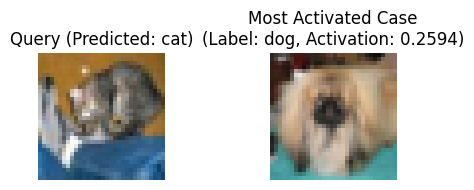

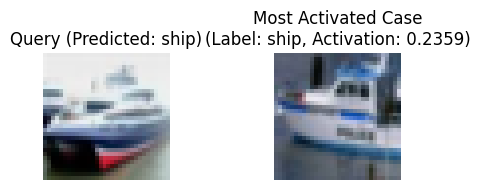

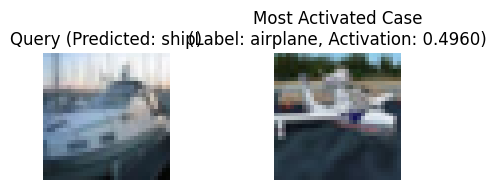

In [ ]:
num_queries = 10  # Number of queries to classify and explain
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # CIFAR-10 classes
stair = 0
# Iterate through the first `num_queries` test samples
for i in range(num_queries):
    query = X_test[i+stair].unsqueeze(0)  # Add batch dimension for the query
    true_label = y_test[i+stair].item()
    results = classify_and_explain(model, query, model.case_nets, classes)

    print(f"Query {i + stair+ 1}:")
    print(f"  True Class: {classes[true_label]}")
    print(f"  Predicted Class: {results['query_prediction']}")
    print(f"  Most Activated Case Label: {results['most_activated_case_label']}")
    print(f"  Most Activated Activation: {results['most_activated_activation']:.4f}")
    print()

In [ ]:
num_queries = 10  # Number of queries to classify and explain
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # CIFAR-10 classes
stair = 10
# Iterate through the first `num_queries` test samples
for i in range(num_queries):
    query = X_test[i+stair].unsqueeze(0)  # Add batch dimension for the query
    true_label = y_test[i+stair].item()
    results = classify_and_explain(model, query, model.case_nets, classes)

    print(f"Query {i + stair+ 1}:")
    print(f"  True Class: {classes[true_label]}")
    print(f"  Predicted Class: {results['query_prediction']}")
    print(f"  Most Activated Case Label: {results['most_activated_case_label']}")
    print(f"  Most Activated Activation: {results['most_activated_activation']:.4f}")
    print()

In [ ]:
num_queries = 10  # Number of queries to classify and explain
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # CIFAR-10 classes
stair = 10
# Iterate through the first `num_queries` test samples
for i in range(num_queries):
    query = X_test[i+stair].unsqueeze(0)  # Add batch dimension for the query
    true_label = y_test[i+stair].item()
    results = classify_and_explain(model, query, model.case_nets, classes)

    print(f"Query {i + stair+ 1}:")
    print(f"  True Class: {classes[true_label]}")
    print(f"  Predicted Class: {results['query_prediction']}")
    print(f"  Most Activated Case Label: {results['most_activated_case_label']}")
    print(f"  Most Activated Activation: {results['most_activated_activation']:.4f}")
    print()

In [ ]:
num_queries = 10  # Number of queries to classify and explain
classes = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]  # CIFAR-10 classes
stair = 8000
# Iterate through the first `num_queries` test samples
for i in range(num_queries):
    query = X_test[i+stair].unsqueeze(0)  # Add batch dimension for the query
    true_label = y_test[i+stair].item()
    results = classify_and_explain(model, query, model.case_nets, classes)

    print(f"Query {i + stair+ 1}:")
    print(f"  True Class: {classes[true_label]}")
    print(f"  Predicted Class: {results['query_prediction']}")
    print(f"  Most Activated Case Label: {results['most_activated_case_label']}")
    print(f"  Most Activated Activation: {results['most_activated_activation']:.4f}")
    print()

## SST

In [ ]:
def classify_and_explain_sst(model, query, vocab, classes, device='cuda'):
    """
    Classify a query sentence and provide the most activated case as an explanation.

    Args:
        model (CaseNetsClassifier): Trained model for classification.
        query (torch.Tensor): Query tensor of shape [seq_len].
        case_nets (list): List of CaseNet objects.
        vocab (torchtext.vocab.Vocab): Vocabulary used for numericalization.
        classes (list): List of class names for the dataset.
        device (str): Device to run the inference on ('cuda' or 'cpu').

    Returns:
        dict: Results containing predictions and explanation.
    """
    model = model.to(device)
    query = query.unsqueeze(0).to(device)  # Add batch dimension [1, seq_len]

    # Classify query and get explanation
    final_predictions, predicted_class, most_activated_cases, most_activated_case_labels, most_activated_activations = model(query)

    results = {"query": None,
                "query_prediction": classes[predicted_class.item()],
                "explanations": []}
    # Get the most activated case and its label
    for i, (case, label, activation) in enumerate(zip(most_activated_cases[0], most_activated_case_labels[0], most_activated_activations[0])):
        most_activated_case = case.cpu().squeeze()
        most_activated_label = torch.argmax(label).item()
        most_activated_activation = activation.item()

        # Decode query and most activated case from indices to tokens
        def decode(tokens, vocab):
            reverse_vocab = {idx: token for token, idx in vocab.items()}  # Create reverse mapping
            return " ".join([reverse_vocab[token.item()] for token in tokens if token.item() != vocab["<pad>"]])

        query_text = decode(query.squeeze().cpu(), vocab)
        results["query"] = query_text
        most_activated_case_text = decode(most_activated_case, vocab)
        # Append explanation to results
        results["explanations"].append({
            "most_activated_case": most_activated_case_text,
            "most_activated_case_label": classes[most_activated_label],
            "most_activated_activation": most_activated_activation
        })
    # Return detailed results
    return results

In [ ]:
import random
random_indices = random.sample(range(len(X_test)), 20)

model.explanation_mode = True
# Loop through the randomly selected queries
for i, query_idx in enumerate(random_indices):  # Loop through the first 20 test queries
    query = X_test[query_idx]  # Get numericalized query tensor
    true_class = y_test[query_idx]  # Get true class label
    # Run the classify_and_explain_sst function
    results = classify_and_explain_sst(model, query, word2idx, classes, device)

    # Print the classification results
    print(f"--- Example {query_idx + 1} ---")
    print(f"Query Sentence: {results['query']}")
    print(f"True Class: {classes[true_class]}")
    print(f"Predicted Class: {results['query_prediction']}")
    for j in range(4):
        print(f"{j}-th most Activated Case Sentence: {results['explanations'][j]['most_activated_case']}")
        print(f"{j}-th most Activated Case Label: {results['explanations'][j]['most_activated_case_label']}")
        print(f"{j}-th most Activated Activation: {results['explanations'][j]['most_activated_activation']:.4f}\n")

--- Example 67 ---
Query Sentence: A taut , intelligent psychological drama .
True Class: Positive
Predicted Class: Positive
0-th most Activated Case Sentence: A poignant and gently humorous parable that loves its characters and communicates something rather beautiful about human nature .
0-th most Activated Case Label: Positive
0-th most Activated Activation: 0.2551

1-th most Activated Case Sentence: A dark , quirky road movie that constantly defies expectation .
1-th most Activated Case Label: Positive
1-th most Activated Activation: 0.2331

2-th most Activated Case Sentence: A sexy , peculiar and always entertaining costume drama set in <unk> Spain , and the fact that it 's based on true events somehow makes it all the more compelling .
2-th most Activated Case Label: Positive
2-th most Activated Activation: 0.2268

3-th most Activated Case Sentence: A must-see for fans of thoughtful war films and those interested in the sights and sounds of battle .
3-th most Activated Case Label: